# Capstone Project Part 2 Models building 
### This code was run on Google Colab Pro

# 1. Connect to Google drive and gain GPU info

In [81]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun May 30 21:11:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free:" + humanize.naturalsize(psutil.virtual_memory().available)," |     Proc size:" + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp37-none-any.whl size=7411 sha256=8e63c3ef35b6255759f20fc02085ce8f9e84b2f665d667c93d26304d3607f939
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free:26.3 GB  |     Proc size:118.4 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total     16280MB


# 2. Import related libs and clean the data

In [5]:
import os
import xml.etree.ElementTree as ET
import glob
import io


In [6]:
def iwslt_clean(directory):
    # Thanks to torchtext for this snippet:
    # https://github.com/pytorch/text/blob/ea64e1d28c794ed6ffc0a5c66651c33e2f57f01f/torchtext/datasets/translation.py#L152
    for xml_filename in glob.iglob(os.path.join(directory, '*.xml')):
        txt_filename = os.path.splitext(xml_filename)[0]
        if os.path.isfile(txt_filename):
            continue

        with io.open(txt_filename, mode='w', encoding='utf-8') as f:
            root = ET.parse(xml_filename).getroot()[0]
            #root = ElementTree.parse(xml_filename).getroot()[0]
            for doc in root.findall('doc'):
                for element in doc.findall('seg'):
                    f.write(element.text.strip() + '\n')

    xml_tags = [
        '<url', '<keywords', '<talkid', '<description', '<reviewer', '<translator', '<title',
        '<speaker'
    ]
    for original_filename in glob.iglob(os.path.join(directory, 'train.tags*')):
        txt_filename = original_filename.replace('.tags', '')
        if os.path.isfile(txt_filename):
            continue

        with io.open(txt_filename, mode='w', encoding='utf-8') as txt_file, \
                io.open(original_filename, mode='r', encoding='utf-8') as original_file:
            for line in original_file:
                if not any(tag in line for tag in xml_tags):
                    txt_file.write(line.strip() + '\n')

In [4]:
iwslt_clean('/project_data/data')

#C:\Users\apple\Downloads\2017-01-trnted\texts\zh\en\zh-en

# 3. Evaluation  BLEU

In [7]:
from typing import List, Iterable, Tuple
from collections import Counter, namedtuple
from itertools import zip_longest
import math
import logging

In [8]:
class BLEU_SCORE(object):
    def __init__(self, NGRAM_ORDER = 4, DEFAULT_TOKENIZER = lambda x:x ):
        self.NGRAM_ORDER = NGRAM_ORDER
        self.DEFAULT_TOKENIZER = DEFAULT_TOKENIZER
        self.BLEU = namedtuple('BLEU', 'score, counts, totals, precisions, bp, sys_len, ref_len')
    
    def _my_log(self, num):
        """
        Floors the log function
        :param num: the number
        :return: log(num) floored to a very low number
        """

        if num == 0.0:
            return -9999999999
        return math.log(num)
    
    def _extract_ngrams(self, line, min_order=1, max_order=None):
        """Extracts all the ngrams (1 <= n <= NGRAM_ORDER) from a sequence of tokens.
        :param line: a segment containing a sequence of words
        :param max_order: collect n-grams from 1<=n<=max
        :return: a dictionary containing ngrams and counts
        """
        if max_order is None:
            max_order = self.NGRAM_ORDER
        ngrams = Counter()
        tokens = line.split()
        for n in range(min_order, max_order + 1):
            for i in range(0, len(tokens) - n + 1):
                ngram = ' '.join(tokens[i: i + n])
                ngrams[ngram] += 1

        return ngrams

    def _ref_stats(self, output, refs):
        ngrams = Counter()
        closest_diff = None
        closest_len = None
        for ref in refs:
            tokens = ref.split()
            reflen = len(tokens)
            diff = abs(len(output.split()) - reflen)
            if closest_diff is None or diff < closest_diff:
                closest_diff = diff
                closest_len = reflen
            elif diff == closest_diff:
                if reflen < closest_len:
                    closest_len = reflen

            ngrams_ref = self._extract_ngrams(ref)
            for ngram in ngrams_ref.keys():
                ngrams[ngram] = max(ngrams[ngram], ngrams_ref[ngram])

        return ngrams, closest_diff, closest_len

    def _compute_bleu(self, correct, total, sys_len, ref_len, smooth = 'none', smooth_floor = 0.01,
                 use_effective_order = False):
        """Computes BLEU score from its sufficient statistics. Adds smoothing.
        :param correct: List of counts of correct ngrams, 1 <= n <= NGRAM_ORDER
        :param total: List of counts of total ngrams, 1 <= n <= NGRAM_ORDER
        :param sys_len: The cumulative system length
        :param ref_len: The cumulative reference length
        :param smooth: The smoothing method to use
        :param smooth_floor: The smoothing value added, if smooth method 'floor' is used
        :param use_effective_order: Use effective order.
        :return: A BLEU object with the score (100-based) and other statistics.
        """

        precisions = [0 for x in range(self.NGRAM_ORDER)]

        smooth_mteval = 1.
        effective_order = self.NGRAM_ORDER
        for n in range(self.NGRAM_ORDER):
            if total[n] == 0:
                break

            if use_effective_order:
                effective_order = n + 1

            if correct[n] == 0:
                if smooth == 'exp':
                    smooth_mteval *= 2
                    precisions[n] = 100. / (smooth_mteval * total[n])
                elif smooth == 'floor':
                    precisions[n] = 100. * smooth_floor / total[n]
            else:
                precisions[n] = 100. * correct[n] / total[n]

        # If the system guesses no i-grams, 1 <= i <= NGRAM_ORDER, the BLEU score is 0 (technically undefined).
        # This is a problem for sentence-level BLEU or a corpus of short sentences, where systems will get no credit
        # if sentence lengths fall under the NGRAM_ORDER threshold. This fix scales NGRAM_ORDER to the observed
        # maximum order. It is only available through the API and off by default

        brevity_penalty = 1.0
        if sys_len < ref_len:
            brevity_penalty = math.exp(1 - ref_len / sys_len) if sys_len > 0 else 0.0

        bleu = brevity_penalty * math.exp(sum(map(self._my_log, precisions[:effective_order])) / effective_order)

        return self.BLEU._make([bleu, correct, total, precisions, brevity_penalty, sys_len, ref_len])
    
    def corpus_bleu(self, sys_stream, ref_streams, smooth='exp', smooth_floor=0.0, force=False, lowercase=False,
                tokenize=None, use_effective_order=False):
        """Produces BLEU scores along with its sufficient statistics from a source against one or more references.
        :param sys_stream: The system stream (a sequence of segments)
        :param ref_streams: A list of one or more reference streams (each a sequence of segments)
        :param smooth: The smoothing method to use
        :param smooth_floor: For 'floor' smoothing, the floor to use
        :param force: Ignore data that looks already tokenized
        :param lowercase: Lowercase the data
        :param tokenize: The tokenizer to use
        :return: a BLEU object containing everything you'd want
        """
        if tokenize is None:
            tokenize = self.DEFAULT_TOKENIZER
        # Add some robustness to the input arguments
        if isinstance(sys_stream, str):
            sys_stream = [sys_stream]
        if isinstance(ref_streams, str):
            ref_streams = [[ref_streams]]

        sys_len = 0
        ref_len = 0

        correct = [0 for n in range(self.NGRAM_ORDER)]
        total = [0 for n in range(self.NGRAM_ORDER)]

        # look for already-tokenized sentences
        tokenized_count = 0

        fhs = [sys_stream] + ref_streams
        for lines in zip_longest(*fhs):
            if None in lines:
                raise EOFError("Source and reference streams have different lengths!")

            if lowercase:
                lines = [x.lower() for x in lines]

            if not (force or tokenize == 'none') and lines[0].rstrip().endswith(' .'):
                tokenized_count += 1

#                 if tokenized_count == 100:
#                     logging.warning('That\'s 100 lines that end in a tokenized period (\'.\')')
#                     logging.warning('It looks like you forgot to detokenize your test data, which may hurt your score.')
#                     logging.warning('If you insist your data is detokenized, or don\'t care, you can suppress this message with \'--force\'.')

            output, *refs = [tokenize(x.rstrip()) for x in lines]

            ref_ngrams, closest_diff, closest_len = self._ref_stats(output, refs)

            sys_len += len(output.split())
            ref_len += closest_len

            sys_ngrams = self._extract_ngrams(output)
            for ngram in sys_ngrams.keys():
                n = len(ngram.split())
                correct[n-1] += min(sys_ngrams[ngram], ref_ngrams.get(ngram, 0))
                total[n-1] += sys_ngrams[ngram]

        return self._compute_bleu(correct, total, sys_len, ref_len, smooth, smooth_floor, use_effective_order)

In [ ]:
#A sample Working Example:
bleu_score = BLEU_SCORE()
pred = ['Today I am going to speak to you  about the last 30 years of architectural history.']
true = ['Today I am going to tell you about the history of architecture over the past 30 years.']
bleu = bleu_score.corpus_bleu(pred,[true], lowercase=True)
print(bleu[0])

30.415590104969052


# 4. Read clean data then tokenize & word2Index

In [9]:
import pandas as pd
import numpy as np
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle
import random
import pdb
from torch.utils.data import DataLoader

from torch import optim
import time

In [15]:
UNK_IDX = 2 # unknown words
PAD_IDX = 3 # padding
SOS_token = 0 # Mark where is the start
EOS_token = 1 # Mark where is the end

In [13]:
def read_dataset(file):
    f = open(file)
    list_l = []
    for line in f:
        list_l.append(line.strip())
    df = pd.DataFrame()
    df['data'] = list_l
    return df


In [16]:
class Lang:
    def __init__(self, name, minimum_count = 3):
        self.name = name
        self.word2index = {}
        self.word2count = {}
#         self.index2word = {0: "SOS", 1: "EOS", 2:"UKN",3:"PAD"}
        self.index2word = ["SOS","EOS","UKN","PAD"]
        self.n_words = 4  # Count SOS and EOS
        self.minimum_count = minimum_count
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word.lower())
#             if word not in string.punctuation:
#                 self.addWord(word.lower())
    def addSentence_zh(self, sentence):
        for word in list(sentence):
            self.addWord(word.lower())

    def addWord(self, word):
        if word not in self.word2count:
            self.word2count[word] = 1
        else:
            self.word2count[word] += 1
        if self.word2count[word] >= self.minimum_count:
            if word not in self.word2index:
                self.word2index[word] = self.n_words
    #             self.index2word[self.n_words] = word
                self.index2word.append(word)
                self.n_words += 1

In [17]:
def split(df, char=False):
    df['en_tokenized'] = df["en_data"].apply(lambda x:x.split( ))
    if char:
        df['zh_tokenized'] = df['zh_data'].apply(lambda x:list(x))
    else:
        df['zh_tokenized'] = df['zh_data'].apply(lambda x:x.split())
    return df

In [18]:
def token2index_dataset(df,en_lang,zh_lang):
    for lan in ['en','zh']:
        indices_data = []
        if lan=='en':
            lang_obj = en_lang
        else:
            lang_obj = zh_lang
        for tokens in df[lan+'_tokenized']:
            index_list = [lang_obj.word2index[token.lower()] if token.lower() in lang_obj.word2index else UNK_IDX for token in tokens]
            index_list.append(EOS_token)
#             index_list.insert(0,SOS_token)
            indices_data.append(index_list)
        df[lan+'_idized'] = indices_data
    return df

In [19]:
def train_val_load(MAX_LEN, old_lang_obj, path, char=False):
    if char:
        en_train = read_dataset(path+"train.en")
        en_val = read_dataset(path+"dev.en")
        en_test = read_dataset(path+"test.en")

        zh_train = read_dataset(path+"train.zh")
        zh_val = read_dataset(path+"dev.zh")
        zh_test = read_dataset(path+"test.zh")

    else:
        en_train = read_dataset(path+"train.tok.en")
        en_val = read_dataset(path+"dev.tok.en")
        en_test = read_dataset(path+"test.tok.en")
        
        zh_train = read_dataset(path+"train.tok.zh")
        zh_val = read_dataset(path+"dev.tok.zh")
        zh_test = read_dataset(path+"test.tok.zh")

    train = pd.DataFrame()
    train['en_data'] = en_train['data']
    train['zh_data'] = zh_train['data']
    
    val = pd.DataFrame()
    val['en_data'] = en_val['data']
    val['zh_data'] = zh_val['data']

    test = pd.DataFrame()
    test['en_data'] = en_test['data']
    test['zh_data'] = zh_test['data']
    
    if old_lang_obj:
        with open(old_lang_obj,'rb') as f:
            en_lang = pickle.load(f)
            zh_lang = pickle.load(f)
    else:
        en_lang = Lang("en")
        for ex in train['en_data']:
            en_lang.addSentence(ex)

        if char:
            zh_lang = Lang("zh")
            for ex in train['zh_data']:
                zh_lang.addSentence_zh(ex)
        else:
            zh_lang = Lang("zh")
            for ex in train['zh_data']:
                zh_lang.addSentence(ex)
        
    train = split(train, char=char)
    val = split(val, char=char)
    test = split(test, char=char)
    
    train = token2index_dataset(train,en_lang,zh_lang)
    val = token2index_dataset(val,en_lang,zh_lang)
    test = token2index_dataset(test,en_lang,zh_lang)

    train['en_len'] = train['en_idized'].apply(lambda x: len(x))
    train['zh_len'] = train['zh_idized'].apply(lambda x:len(x))
    
    val['en_len'] = val['en_idized'].apply(lambda x: len(x))
    val['zh_len'] = val['zh_idized'].apply(lambda x: len(x))

    test['en_len'] = test['en_idized'].apply(lambda x: len(x))
    test['zh_len'] = test['zh_idized'].apply(lambda x: len(x))
    
    train = train[np.logical_and(train['en_len']>=2,train['zh_len']>=2)]
#     train = train[train['vi_len']<=MAX_LEN]
    
    val = val[np.logical_and(val['en_len']>=2,val['zh_len']>=2)]
#     val = val[val['vi_len']<=MAX_LEN]
    
    test = test[np.logical_and(test['en_len']>=2,test['zh_len']>=2)]
#     train = train[train['vi_len']<=MAX_LEN]

    return train,val,test,en_lang,zh_lang

In [20]:
! pip install pyplotz


  Created wheel for pyplotz: filename=pyplotz-0.24-cp37-none-any.whl size=3665 sha256=80c10310b167e4135a31e03f16afb85c1d2f01cdb58744bb90984a705737e79d
  Stored in directory: /root/.cache/pip/wheels/c2/60/51/0dd5298dfbd33ea0dc7fa6e860903199d685249a1ab3362c89
Successfully built pyplotz


In [21]:
from pyplotz.pyplotz import PyplotZ


In [22]:
import pandas as pd
import numpy as np
import unicodedata
import string
import re
import random
from collections import Counter
import pickle
import random
import pdb
import logging
import itertools
import argparse
import math
import copy
import time
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import optim
import torchtext
from torch.utils.data import BatchSampler
from torch.utils.data import SequentialSampler
from torch.utils.data import Sampler
from torch.optim.lr_scheduler import ReduceLROnPlateau

#from bleu_score import BLEU_SCORE
#from load_dataset_zh_wcharoption import *

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
import matplotlib as mpl

In [23]:
#device = torch.device('cuda')
#device = torch.device('cpu')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
# memory footprint support libraries/code
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
# !pip install psutil
# !pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free:" + humanize.naturalsize(psutil.virtual_memory().available)," |     Proc size:" + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp37-none-any.whl size=7411 sha256=72c6de55caed99ac99508ca746a14784b6b71fa63a32b4c6f6996e28ba581db0
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free:26.2 GB  |     Proc size:307.1 MB
GPU RAM Free: 16278MB | Used: 2MB | Util   0% | Total     16280MB


# 5. Build data loaders

In [25]:
class Chinese(Dataset):
    def __init__(self, df, val = False):
        self.df = df
        self.val = val
        
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        english = self.df.iloc[idx,:]['en_idized']
        chin = self.df.iloc[idx,:]['zh_idized']
        en_len = self.df.iloc[idx,:]['en_len']
        zh_len = self.df.iloc[idx,:]['zh_len']
        if self.val:
            en_data = self.df.iloc[idx,:]['en_data'].lower()
            return [chin,english,zh_len,en_len,en_data]
        else:
            return [chin,english,zh_len,en_len]
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
def vocab_collate_func(batch):
    MAX_LEN_EN = 48
    MAX_LEN_zh = 48
    en_data = []
    zh_data = []
    en_len = []
    zh_len = []
    for datum in batch:
        en_len.append(datum[3])
        zh_len.append(datum[2])
    max_batch_length_en = max(en_len)
    max_batch_length_zh = max(zh_len)
    if max_batch_length_en < MAX_LEN_EN:
        MAX_LEN_EN = max_batch_length_en
    if max_batch_length_zh < MAX_LEN_zh:
        MAX_LEN_zh = max_batch_length_zh
    # padding
    for datum in batch:
        if datum[2]>MAX_LEN_zh:
            padded_vec_s1 = np.array(datum[0])[:MAX_LEN_zh]
        else:
            padded_vec_s1 = np.pad(np.array(datum[0]),
                                pad_width=((0,MAX_LEN_zh - datum[2])),
                                mode="constant", constant_values=PAD_IDX)
        if datum[3]>MAX_LEN_EN:
            padded_vec_s2 = np.array(datum[1])[:MAX_LEN_EN]
        else:
            padded_vec_s2 = np.pad(np.array(datum[1]),
                                pad_width=((0,MAX_LEN_EN - datum[3])),
                                mode="constant", constant_values=PAD_IDX)
        en_data.append(padded_vec_s2)
        zh_data.append(padded_vec_s1)
    zh_data = np.array(zh_data)
    en_data = np.array(en_data)
    zh_len = np.array(zh_len)
    en_len = np.array(en_len)

    zh_len[zh_len>MAX_LEN_zh] = MAX_LEN_zh
    en_len[en_len>MAX_LEN_EN] = MAX_LEN_EN
        
    return [torch.from_numpy(zh_data), torch.from_numpy(en_data),
            torch.from_numpy(zh_len), torch.from_numpy(en_len)]

def convert_idx_2_sent(tensor, lang_obj):
    word_list = []
    for i in tensor:
        if i.item() not in set([PAD_IDX,EOS_token,SOS_token]):
            word_list.append(lang_obj.index2word[i.item()])
    return (' ').join(word_list)

def convert_id_list_2_sent(list_idx, lang_obj):
    word_list = []
    if type(list_idx) == list:
        for i in list_idx:
            if i not in set([EOS_token]):
                word_list.append(lang_obj.index2word[i])
    else:
        for i in list_idx:
            if i.item() not in set([EOS_token,SOS_token,PAD_IDX]):
                word_list.append(lang_obj.index2word[i.item()])
    return (' ').join(word_list)

In [26]:
def vocab_collate_func_val(batch):
    return [torch.from_numpy(np.array(batch[0][0])).unsqueeze(0), torch.from_numpy(np.array(batch[0][1])).unsqueeze(0),
            torch.from_numpy(np.array(batch[0][2])).unsqueeze(0), torch.from_numpy(np.array(batch[0][3])).unsqueeze(0),batch[0][4]]



---



---


Use character level Chinese or not

---




In [27]:
# MAX_LEN = 57
#train,val,test,en_lang,zh_lang = train_val_load(57, "", '/project_data/', char=False)
# use character level chinese
train,val,test,en_lang,zh_lang = train_val_load(57, "", '/content/drive/MyDrive/processed_data/', char=True)

In [28]:
train.shape

(1205, 8)

In [28]:
val.head()

,en_data,zh_data,en_tokenized,zh_tokenized,en_idized,zh_idized,en_len,zh_len
0,Last year I showed these two slides so that d...,去年我给各位展示了两个 关于北极冰帽的演示 在过去三百万年中 其面积由相当于美国南方48州面...,"[Last, year, I, showed, these, two, slides, so...","[去, 年, 我, 给, 各, 位, 展, 示, 了, 两, 个, , 关, 于, 北, ...","[58, 562, 12, 2, 88, 125, 2, 42, 13, 2, 13, 11...","[118, 45, 8, 293, 387, 247, 211, 472, 53, 237,...",39,57
1,But this understates the seriousness of this p...,但这些没能完全说明这个问题的严重性 因为这没有表示出冰帽的厚度,"[But, this, understates, the, seriousness, of,...","[但, 这, 些, 没, 能, 完, 全, 说, 明, 这, 个, 问, 题, 的, 严, ...","[124, 29, 2, 11, 2, 24, 29, 2, 363, 23, 33, 15...","[355, 4, 64, 290, 32, 99, 192, 172, 200, 4, 15...",19,32
2,"The arctic ice cap is, in a sense, the beatin...",感觉上，北极冰帽 就好象全球气候系统中跳动的心脏,"[The, arctic, ice, cap, is,, in, a, sense,, th...","[感, 觉, 上, ，, 北, 极, 冰, 帽, , 就, 好, 象, 全, 球, 气, ...","[11, 2, 2, 2, 537, 7, 5, 2, 11, 2, 2, 24, 11, ...","[34, 257, 205, 10, 2, 554, 2, 2, 6, 28, 331, 2...",17,25
3,It expands in winter and contracts in summer.,冬天心脏舒张，夏天心脏收缩,"[It, expands, in, winter, and, contracts, in, ...","[冬, 天, 心, 脏, 舒, 张, ，, 夏, 天, 心, 脏, 收, 缩]","[33, 2, 7, 2, 8, 2, 7, 2, 1]","[2, 138, 249, 2, 1077, 652, 10, 2, 138, 249, 2...",9,14
4,The next slide I show you will be a rapid fas...,下面我要展示的是 在过去25年里的极剧变化,"[The, next, slide, I, show, you, will, be, a, ...","[下, 面, 我, 要, 展, 示, 的, 是, , 在, 过, 去, 2, 5, 年, ...","[11, 277, 2, 12, 214, 26, 205, 104, 5, 2, 2, 2...","[350, 155, 8, 87, 211, 472, 5, 12, 6, 11, 88, ...",20,22


In [29]:
train.head()

,en_data,zh_data,en_tokenized,zh_tokenized,en_idized,zh_idized,en_len,zh_len
0,Today I'm going to speak to you about the las...,今天我要跟大家讲述 过去30年的建筑史。,"[Today, I'm, going, to, speak, to, you, about,...","[今, 天, 我, 要, 跟, 大, 家, 讲, 述, , 过, 去, 3, 0, 年, ...","[790, 293, 118, 4, 775, 4, 26, 20, 11, 58, 59,...","[295, 138, 8, 87, 391, 94, 17, 269, 270, 6, 88...",16,21
1,That's a lot to pack into 18 minutes.,太多东西要在这18分钟内讲述了。,"[That's, a, lot, to, pack, into, 18, minutes.]","[太, 多, 东, 西, 要, 在, 这, 1, 8, 分, 钟, 内, 讲, 述, 了, 。]","[19, 5, 270, 4, 2, 69, 794, 2, 1]","[147, 52, 69, 9, 87, 11, 4, 174, 148, 100, 128...",9,17
2,"It's a complex topic, so we're just going to ...",这是一个复杂的题目， 那就让我们从这个复杂的地方开始： 新泽西。,"[It's, a, complex, topic,, so, we're, just, go...","[这, 是, 一, 个, 复, 杂, 的, 题, 目, ，, , 那, 就, 让, 我, ...","[21, 5, 390, 2, 42, 52, 79, 118, 4, 2, 308, 7,...","[4, 12, 95, 15, 364, 661, 5, 345, 360, 10, 6, ...",19,33
3,"Because 30 years ago, I'm from Jersey, and I ...",三十年前，我住新泽西 那时我六岁，我住在父母家 小镇名叫Livingston， 这是我儿时的卧室。,"[Because, 30, years, ago,, I'm, from, Jersey,,...","[三, 十, 年, 前, ，, 我, 住, 新, 泽, 西, , 那, 时, 我, 六, ...","[23, 59, 27, 322, 293, 14, 2, 8, 12, 10, 2, 8,...","[313, 431, 45, 56, 10, 8, 63, 72, 883, 9, 6, 1...",31,50
4,Around the corner from my bedroom was the bat...,在我卧室的角落 是我和姐姐共用的洗手间。,"[Around, the, corner, from, my, bedroom, was, ...","[在, 我, 卧, 室, 的, 角, 落, , 是, 我, 和, 姐, 姐, 共, 用, ...","[92, 11, 891, 14, 9, 15, 10, 11, 2, 13, 12, 32...","[11, 8, 13, 14, 5, 690, 328, 6, 12, 8, 42, 976...",18,21


In [30]:
test.head()

,en_data,zh_data,en_tokenized,zh_tokenized,en_idized,zh_idized,en_len,zh_len
0,Today I'm going to speak to you about the las...,今天我要跟大家讲述 过去30年的建筑史。,"[Today, I'm, going, to, speak, to, you, about,...","[今, 天, 我, 要, 跟, 大, 家, 讲, 述, , 过, 去, 3, 0, 年, ...","[790, 293, 118, 4, 775, 4, 26, 20, 11, 58, 59,...","[295, 138, 8, 87, 391, 94, 17, 269, 270, 6, 88...",16,21
1,That's a lot to pack into 18 minutes.,太多东西要在这18分钟内讲述了。,"[That's, a, lot, to, pack, into, 18, minutes.]","[太, 多, 东, 西, 要, 在, 这, 1, 8, 分, 钟, 内, 讲, 述, 了, 。]","[19, 5, 270, 4, 2, 69, 794, 2, 1]","[147, 52, 69, 9, 87, 11, 4, 174, 148, 100, 128...",9,17
2,"It's a complex topic, so we're just going to ...",这是一个复杂的题目， 那就让我们从这个复杂的地方开始： 新泽西。,"[It's, a, complex, topic,, so, we're, just, go...","[这, 是, 一, 个, 复, 杂, 的, 题, 目, ，, , 那, 就, 让, 我, ...","[21, 5, 390, 2, 42, 52, 79, 118, 4, 2, 308, 7,...","[4, 12, 95, 15, 364, 661, 5, 345, 360, 10, 6, ...",19,33
3,"Because 30 years ago, I'm from Jersey, and I ...",三十年前，我住新泽西 那时我六岁，我住在父母家 小镇名叫Livingston， 这是我儿时的卧室。,"[Because, 30, years, ago,, I'm, from, Jersey,,...","[三, 十, 年, 前, ，, 我, 住, 新, 泽, 西, , 那, 时, 我, 六, ...","[23, 59, 27, 322, 293, 14, 2, 8, 12, 10, 2, 8,...","[313, 431, 45, 56, 10, 8, 63, 72, 883, 9, 6, 1...",31,50
4,Around the corner from my bedroom was the bat...,在我卧室的角落 是我和姐姐共用的洗手间。,"[Around, the, corner, from, my, bedroom, was, ...","[在, 我, 卧, 室, 的, 角, 落, , 是, 我, 和, 姐, 姐, 共, 用, ...","[92, 11, 891, 14, 9, 15, 10, 11, 2, 13, 12, 32...","[11, 8, 13, 14, 5, 690, 328, 6, 12, 8, 42, 976...",18,21


In [31]:
bs_dict = {'train':128,'validate':1, 'train_val':1,'val_train':128, 'test':1}
shuffle_dict = {'train':True,'validate':False, 'train_val':False,'val_train':True, 'test':False}

train_used = train
val_used = val

collate_fn_dict = {'train':vocab_collate_func, 'validate':vocab_collate_func_val,\
                   'train_val':vocab_collate_func_val,'val_train':vocab_collate_func,'test': vocab_collate_func_val}
transformed_dataset = {'train': Chinese(train_used),
                       'validate': Chinese(val_used, val = True),
                       'train_val':Chinese(train.iloc[:50], val = True),
                       'val_train':Chinese(val_used),
                       'test':Chinese(test, val= True)
                                               }

dataloader = {x: DataLoader(transformed_dataset[x], batch_size=bs_dict[x], collate_fn=collate_fn_dict[x],
                    shuffle=shuffle_dict[x], num_workers=0) for x in ['train', 'validate', 'train_val','val_train', 'test']}

# 6. Build Models 

In [32]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, embed_dim, hidden_size,n_layers, rnn_type = 'lstm', device = 'cuda'):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = Embedding(input_size, embed_dim, PAD_IDX)
        self.rnn_type =  rnn_type
        self.dropout_in = nn.Dropout(p = 0.1)
        self.n_layers = n_layers
        self.device = device
        if rnn_type == 'gru':
            self.rnn = nn.GRU(embed_dim, hidden_size,batch_first=True,bidirectional=True, num_layers = self.n_layers, dropout = 0.2)
        elif rnn_type == 'lstm':
            self.rnn = LSTM(embed_dim, hidden_size, batch_first=True,bidirectional=True, num_layers = n_layers,dropout = 0.2)

    def forward(self, enc_inp, src_len):
        sorted_idx = torch.sort(src_len, descending=True)[1]
        orig_idx = torch.sort(sorted_idx)[1]
        embedded = self.embedding(enc_inp)
        bs = embedded.size(0)
        output = self.dropout_in(embedded)
        if self.rnn_type == 'gru':
            hidden =  self.initHidden(bs)
            sorted_output = output[sorted_idx]
            sorted_len = src_len[sorted_idx]
            packed_output = nn.utils.rnn.pack_padded_sequence(sorted_output, sorted_len.data.tolist(), batch_first = True)
            packed_outs, hiddden = self.rnn(packed_output,(hidden, c))
            hidden = hidden[:,orig_idx,:]
            output, _ = nn.utils.rnn.pad_packed_sequence(packed_outs, padding_value=PAD_IDX, batch_first = True)
            output = output[orig_idx]
            hidden = hidden.view(self.n_layers, 2, bs, -1).transpose(1, 2).contiguous().view(self.n_layers, bs, -1)
            return output, hidden, hidden
        elif self.rnn_type == 'lstm':
            hidden, c = self.initHidden(bs)
            sorted_output = output[sorted_idx]
            sorted_len = src_len[sorted_idx]
            packed_output = nn.utils.rnn.pack_padded_sequence(sorted_output, sorted_len.data.tolist(), batch_first = True)
            packed_outs, (hiddden, c) = self.rnn(packed_output,(hidden, c))
            hidden = hidden[:,orig_idx,:]
            c = c[:,orig_idx,:]
            output, _ = nn.utils.rnn.pad_packed_sequence(packed_outs, padding_value=PAD_IDX, batch_first = True)
            output = output[orig_idx]
            c = c.view(self.n_layers, 2, bs, -1).transpose(1, 2).contiguous().view(self.n_layers, bs, -1)
            hidden = hidden.view(self.n_layers, 2, bs, -1).transpose(1, 2).contiguous().view(self.n_layers, bs, -1)
            return output, hidden, c
        
    def initHidden(self,bs):
        if self.rnn_type == 'gru' :
            return torch.zeros(self.n_layers*2, bs, self.hidden_size).to(self.device)
        elif self.rnn_type == 'lstm':
            return torch.zeros(self.n_layers*2,bs,self.hidden_size).to(self.device),torch.zeros(self.n_layers*2,bs,self.hidden_size).to(self.device)

class Attention_Module(nn.Module):
    def __init__(self, hidden_dim, output_dim, device = 'cuda'):
        super(Attention_Module, self).__init__()
        self.l1 = Linear(hidden_dim, output_dim, bias = False)
        self.l2 = Linear(hidden_dim+output_dim, output_dim, bias =  False)
        self.device = device
        
    def forward(self, hidden, encoder_outs, src_lens):
        ''' hiddden: bsz x hidden_dim
        encoder_outs: bsz x sq_len x encoder dim (output_dim)
        src_lens: bsz
        
        x: bsz x output_dim
        attn_score: bsz x sq_len'''
        x = self.l1(hidden)
        att_score = (encoder_outs.transpose(0,1) * x.unsqueeze(0)).sum(dim = 2)
        seq_mask = sequence_mask(src_lens, max_len = max(src_lens).item(), device = self.device).transpose(0,1)
        masked_att = seq_mask*att_score
        masked_att[masked_att==0] = -1e10
        attn_scores = F.softmax(masked_att, dim=0)
        x = (attn_scores.unsqueeze(2) * encoder_outs.transpose(0,1)).sum(dim=0)
        x = torch.tanh(self.l2(torch.cat((x, hidden), dim=1)))
        return x, attn_scores
        
class AttentionDecoderRNN(nn.Module):
    def __init__(self, output_size, embed_dim, hidden_size, n_layers = 1, attention = True, device = 'cuda'):
        super(AttentionDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        encoder_output_size = hidden_size
        self.embedding = Embedding(output_size, embed_dim, PAD_IDX)
        self.dropout = nn.Dropout(p=0.1)
        self.n_layers = n_layers
        self.device = device
        self.att_layer = Attention_Module(self.hidden_size, encoder_output_size,self.device) if attention else None
        self.layers = nn.ModuleList([
            LSTMCell(
                input_size=self.hidden_size + embed_dim if ((layer == 0) and attention) else embed_dim if layer == 0 else hidden_size,
                hidden_size=hidden_size,
            )
            for layer in range(self.n_layers)
        ])
        self.fc_out = nn.Linear(self.hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, dec_input,context_vector, prev_hiddens,prev_cs,encoder_outputs,src_len):
        bsz = dec_input.size(0)
        output = self.embedding(dec_input)
        output = self.dropout(output)
        if self.att_layer is not None:
            cated_input = torch.cat([output.squeeze(1),context_vector], dim = 1)
        else:
            cated_input = output.squeeze(1)
        new_hiddens = []
        new_cs = []
        for i, rnn in enumerate(self.layers):
            hidden, c = rnn(cated_input, (prev_hiddens[i], prev_cs[i]))
            cated_input = self.dropout(hidden)
            new_hiddens.append(hidden.unsqueeze(0))
            new_cs.append(c.unsqueeze(0))
        new_hiddens = torch.cat(new_hiddens, dim = 0)
        new_cs = torch.cat(new_cs, dim = 0)

        # apply attention using the last layer's hidden state
        if self.att_layer is not None:
            out, attn_score = self.att_layer(hidden, encoder_outputs, src_len)
        else:
            out = hidden
            attn_score = None
        context_vec = out
        out = self.dropout(out)
        out_vocab = self.softmax(self.fc_out(out))

        return out_vocab, context_vec, new_hiddens, new_cs, attn_score

# 7. Utilites functions, training and evaluation functions 

In [33]:
!fc-list :lang=zh family

In [34]:
# 下载--解压--移动字体文件
!wget "https://www.wfonts.com/download/data/2014/06/01/simhei/simhei.zip"
!unzip "simhei.zip"
!rm "simhei.zip"
!mv SimHei.ttf /usr/share/fonts/truetype/

--2021-05-30 21:15:37--  https://www.wfonts.com/download/data/2014/06/01/simhei/simhei.zip
Resolving www.wfonts.com (www.wfonts.com)... 104.225.219.210
Connecting to www.wfonts.com (www.wfonts.com)|104.225.219.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10546298 (10M) [application/octetstream]
Saving to: ‘simhei.zip’

simhei.zip          100%[===================>]  10.06M  8.76MB/s    in 1.1s    

2021-05-30 21:15:39 (8.76 MB/s) - ‘simhei.zip’ saved [10546298/10546298]

Archive:  simhei.zip
  inflating: chinese.simhei.ttf      
  inflating: SimHei.ttf              
  inflating: sharefonts.net.txt      


In [39]:
import matplotlib.font_manager as fm
import seaborn as sns
path = '/usr/share/fonts/truetype/SimHei.ttf'
fontprop = fm.FontProperties(fname=path, size=13)
sns.set(font=fontprop.get_name())

In [40]:
def Embedding(num_embeddings, embedding_dim, padding_idx):
    m = nn.Embedding(num_embeddings, embedding_dim, padding_idx=padding_idx)
    nn.init.uniform_(m.weight, -0.1, 0.1)
    nn.init.constant_(m.weight[padding_idx], 0)
    return m


def LSTM(input_size, hidden_size, **kwargs):
    m = nn.LSTM(input_size, hidden_size,**kwargs)
    for name, param in m.named_parameters():
        if 'weight' in name or 'bias' in name:
            param.data.uniform_(-0.1, 0.1)
    return m


def LSTMCell(input_size, hidden_size, **kwargs):
    m = nn.LSTMCell(input_size, hidden_size,**kwargs)
    for name, param in m.named_parameters():
        if 'weight' in name or 'bias' in name:
            param.data.uniform_(-0.1, 0.1)
    return m


def Linear(in_features, out_features, bias=True, dropout=0):
    """Linear layer (input: N x T x C)"""
    m = nn.Linear(in_features, out_features, bias=bias)
    m.weight.data.uniform_(-0.1, 0.1)
    if bias:
        m.bias.data.uniform_(-0.1, 0.1)
    return m

In [41]:
def sequence_mask(sequence_length, max_len=None, device = device):
    if max_len is None:
        max_len = sequence_length.max().item()
    batch_size = sequence_length.size(0)
    seq_range = torch.arange(0, max_len).long()
    seq_range_expand = seq_range.unsqueeze(0).repeat([batch_size,1])
    seq_range_expand = seq_range_expand.to(device)
    seq_length_expand = (sequence_length.unsqueeze(1)
                         .expand_as(seq_range_expand))
    return (seq_range_expand < seq_length_expand).float()

In [42]:
def encode_decode(encoder,decoder,data_en,data_de,src_len,tar_len,rand_num = 0.95, val = False):
    if not val:
        use_teacher_forcing = True if random.random() < rand_num else False
    #     print("tar_len",tar_len)
        bss = data_en.size(0)
        en_out,en_hid,en_c = encoder(data_en, src_len)
        max_src_len_batch = max(src_len).item()
        max_tar_len_batch = max(tar_len).item()
        prev_hiddens = en_hid
        prev_cs = en_c
        decoder_input = torch.tensor([[SOS_token]]*bss).to(device)
        prev_output = torch.zeros((bss, en_out.size(-1))).to(device)
        if use_teacher_forcing:
            d_out = []
            for i in range(max_tar_len_batch):
                out_vocab, prev_output,prev_hiddens, prev_cs, attention_score = decoder(decoder_input,prev_output, \
                                                                                        prev_hiddens,prev_cs, en_out,\
                                                                                        src_len)
                d_out.append(out_vocab.unsqueeze(-1))
                decoder_input = data_de[:,i].view(-1,1)
            d_out = torch.cat(d_out,dim=-1)
        else:
            d_out = []
            for i in range(max_tar_len_batch):
                out_vocab, prev_output,prev_hiddens, prev_cs, attention_score = decoder(decoder_input,prev_output, \
                                                                                        prev_hiddens,prev_cs, en_out,\
                                                                                        src_len)
                d_out.append(out_vocab.unsqueeze(-1))
                topv, topi = out_vocab.topk(1)
                decoder_input = topi.squeeze().detach().view(-1,1)
            d_out = torch.cat(d_out,dim=-1)
        return d_out
    else:
        encoder.eval()
        decoder.eval()
        bss = data_en.size(0)
        en_out,en_hid,en_c = encoder(data_en, src_len)
        max_src_len_batch = max(src_len).item()
        max_tar_len_batch = max(tar_len).item()
        prev_hiddens = en_hid
        prev_cs = en_c
        decoder_input = torch.tensor([[SOS_token]]*bss).to(device)
        prev_output = torch.zeros((bss, en_out.size(-1))).to(device)
        d_out = []
        for i in range(max_tar_len_batch):
            out_vocab, prev_output,prev_hiddens, prev_cs, attention_score = decoder(decoder_input,prev_output, \
                                                                                    prev_hiddens,prev_cs, en_out,\
                                                                                    src_len)
            d_out.append(out_vocab.unsqueeze(-1))
            topv, topi = out_vocab.topk(1)
            decoder_input = topi.squeeze().detach().view(-1,1)
        d_out = torch.cat(d_out,dim=-1)
        return d_out

In [43]:
def flatten_cel_loss(input,target,nll):
    input = input.transpose(1,2)
    bs, sl = input.size()[:2]
    return nll(input.contiguous().view(bs*sl,-1),target.contiguous().view(-1))

In [44]:
def validation_new(encoder, decoder, val_dataloader, lang_en,lang_zh,m_type, verbose = False, replace_unk = False):
    encoder.eval()
    decoder.eval()
    pred_corpus = []
    true_corpus = []
    src_corpus = []
    running_loss = 0
    running_total = 0
    bl = BLEU_SCORE()
    attention_scores_for_all_val = []
    for data in val_dataloader:
        encoder_i = data[0].to(device)
        src_len = data[2].to(device)
        bs,sl = encoder_i.size()[:2]
        en_out,en_hid,en_c = encoder(encoder_i,src_len)
        max_src_len_batch = max(src_len).item()
        prev_hiddens = en_hid
        prev_cs = en_c
        decoder_input = torch.tensor([[SOS_token]]*bs).to(device)
        prev_output = torch.zeros((bs, en_out.size(-1))).to(device)
        d_out = []
        attention_scores = []
        for i in range(sl*2):
            out_vocab, prev_output,prev_hiddens, prev_cs, attention_score = decoder(decoder_input,prev_output, \
                                                                                    prev_hiddens,prev_cs, en_out,\
                                                                                    src_len)
            topv, topi = out_vocab.topk(1)
#             decoder_input = topi.squeeze().detach().view(-1,1)
            d_out.append(topi.item())
            decoder_input = topi.squeeze().detach().view(-1,1)
            if m_type == 'attention':
                attention_scores.append(attention_score.unsqueeze(-1))
            if topi.item() == EOS_token:
                break
        

#         true_sent = convert_id_list_2_sent(data[1][0],lang_en)
#         true_corpus.append(true_sent)
        if replace_unk:
            true_sent = convert_id_list_2_sent(data[1][0],lang_en)
            true_corpus.append(true_sent)
        else:
            true_corpus.append(data[-1])
        src_sent = convert_id_list_2_sent(data[0][0],lang_zh)
        src_corpus.append(src_sent)
        pred_sent = convert_id_list_2_sent(d_out,lang_en)
        pred_corpus.append(pred_sent)
        if m_type == 'attention':
            attention_scores = torch.cat(attention_scores, dim = -1)
            attention_scores_for_all_val.append(attention_scores)
        if verbose:
            print("True Sentence:",data[-1])
            print("Pred Sentence:", pred_sent)
            print('-*'*50)
    score = bl.corpus_bleu(pred_corpus,[true_corpus],lowercase=True)[0]
    return score, attention_scores_for_all_val, pred_corpus, src_corpus

In [45]:
###this one works


def validation_beam_search(encoder, decoder, val_dataloader,lang_en,lang_zh,m_type, beam_size, verbose = False,\
                           device = device, replace_unk = False):
    encoder.eval()
    decoder.eval()
    encoder = encoder.to(device)
    decoder = decoder.to(device)
    pred_corpus = []
    true_corpus = []
    src_corpus = []
    running_loss = 0
    running_total = 0
    bl = BLEU_SCORE()
    j = 0
    attention_scores_for_all_val = []
    for data in val_dataloader:
#         print(j)
        encoder_i = data[0].to(device)
        src_len = data[2].to(device)
        bs,sl = encoder_i.size()[:2]
        en_out,en_hid,en_c = encoder(encoder_i,src_len)
        max_src_len_batch = max(src_len).item()
        prev_hiddens = en_hid
        prev_cs = en_c
        decoder_input = torch.tensor([[SOS_token]]*bs).to(device)
        prev_output = torch.zeros((bs, en_out.size(-1))).to(device)
        list_decoder_input = [None]*beam_size
        beam_stop_flags = [False]*beam_size
        beam_score = torch.zeros((bs,beam_size)).to(device)
        list_d_outs = [[] for _ in range(beam_size)]
        select_beam_size = beam_size
        attention_scores = [[] for _ in range(beam_size)]
        for i in range(sl+20):
            if i == 0:
                out_vocab, prev_output,prev_hiddens, prev_cs, attention_score = decoder(decoder_input,prev_output, \
                                                                                    prev_hiddens,prev_cs, en_out,\
                                                                                    src_len)
                bss, vocab_size = out_vocab.size()
                topv, topi = out_vocab.topk(beam_size)
                list_prev_output = [prev_output]*beam_size
                list_prev_hiddens = [prev_hiddens]*beam_size
                list_prev_cs = [prev_cs]*beam_size
                for b in range(beam_size):
                    beam_score[0][b] = topv[0][b].item()
                    list_decoder_input[b] = topi[0][b].squeeze().detach().view(-1,1)
                    list_d_outs[b].append(topi[0][b].item())
                    if m_type == 'attention':
                        attention_scores[b].append(attention_score.unsqueeze(-1))
                    if topi[0][b].item() == EOS_token:
                        beam_stop_flags[b] = True
            else:
                beam_out_vocab = [None]*beam_size
                temp_out = [None]*beam_size
                temp_hid = [None]*beam_size
                temp_c = [None]*beam_size
                temp_attention_score = [[] for _ in range(beam_size)]
                prev_d_outs = copy.deepcopy(list_d_outs)
                for b in range(beam_size):
                    if not beam_stop_flags[b]:
                        beam_out_vocab[b], temp_out[b], temp_hid[b], temp_c[b], temp_attention_score[b] =\
                            decoder(list_decoder_input[b],list_prev_output[b],list_prev_hiddens[b],list_prev_cs[b],\
                                    en_out,src_len)
                        beam_out_vocab[b] = beam_out_vocab[b] + beam_score[0][b]
                    if beam_stop_flags[b]:
                        beam_out_vocab[b] = torch.zeros(bss,vocab_size).fill_(float('-inf')).to(device)
                beam_out_vocab = torch.cat(beam_out_vocab,dim = 1)
                
                topv, topi = beam_out_vocab.topk(beam_size)
                id_for_hid = topi//vocab_size
                topi_idx = topi%vocab_size
                for b in range(beam_size):
                    if not beam_stop_flags[b]:
                        beam_score[0][b] = topv[0][b].item()
                        list_decoder_input[b] = topi_idx[0][b].squeeze().detach().view(-1,1)
                        list_d_outs[b] = copy.deepcopy(prev_d_outs[id_for_hid[0][b]])
                        list_d_outs[b].append(topi_idx[0][b].item())
                        if m_type == 'attention':
                            attention_scores[b].append(temp_attention_score[b].unsqueeze(-1))
                        if topi_idx[0][b].item() == EOS_token:
                            beam_stop_flags[b] = True
                        else:
                            list_prev_output[b] = temp_out[id_for_hid[0][b]]
                            list_prev_hiddens[b] = temp_hid[id_for_hid[0][b]]
                            list_prev_cs[b] = temp_c[id_for_hid[0][b]]
                if all(beam_stop_flags):
                    break
        id_max_score = torch.argmax(beam_score)
        #self.Tensor.weight.data.cpu().numpy()
        #Tensor.weight.data.cpu().numpy()



        d_out = list_d_outs[id_max_score]

        if m_type == 'attention':
            att_score = attention_scores[id_max_score]
            att_score = torch.cat(att_score, dim = -1)
            attention_scores_for_all_val.append(att_score)
        if replace_unk:
            true_sent = convert_id_list_2_sent(data[1][0],lang_en)
            true_corpus.append(true_sent)
        else:
            true_corpus.append(data[-1])
        pred_sent = convert_id_list_2_sent(d_out,lang_en)
        pred_corpus.append(pred_sent)
        src_sent = convert_id_list_2_sent(data[0][0], lang_zh)
        src_corpus.append(src_sent)
        if verbose:
            print("True Sentence:",data[-1])
            print("Pred Sentence:", pred_sent)
            print('-*'*50)
    score = bl.corpus_bleu(pred_corpus,[true_corpus],lowercase=True)[0]
  
    return  score, attention_scores_for_all_val, pred_corpus, src_corpus

In [46]:
def train_model(encoder_optimizer,decoder_optimizer, encoder, decoder, loss_fun,m_type, dataloader, en_lang,zh_lang,\
                num_epochs=15, val_every = 1, train_bleu_every = 10,clip = 0.1, rm = 0.8, enc_scheduler = None,\
               dec_scheduler = None, enc_dec_fn = encode_decode, val_fn = validation_new):
    best_score = 0
    best_bleu = 0
    loss_hist = {'train': [], 'val_train': []}
    bleu_hist = {'train': [], 'validate': []}
    best_encoder_wts = None
    best_decoder_wts = None
    phases = ['train','val_train']
    for epoch in range(num_epochs):
        for ex, phase in enumerate(phases):
            start = time.time()
            total = 0
            top1_correct = 0
            running_loss = 0
            running_total = 0
            if phase == 'train':
                encoder.train()
                decoder.train()
            else:
                encoder.eval()
                decoder.eval()
            for data in dataloader[phase]:
                encoder_optimizer.zero_grad()
                decoder_optimizer.zero_grad()

                encoder_i = data[0].to(device)
                decoder_i = data[1].to(device)
                src_len = data[2].to(device)
                tar_len = data[3].to(device)
                if phase == 'val_train':  
                    out = enc_dec_fn(encoder,decoder,encoder_i,decoder_i,src_len,tar_len,rand_num=rm,val = True )
                else:
                    out = enc_dec_fn(encoder,decoder,encoder_i,decoder_i,src_len,tar_len,rand_num=rm,val = False )
                N = decoder_i.size(0)
                loss = loss_fun(out.float(), decoder_i.long())
                running_loss += loss.item() * N
                
                total += N
                if phase == 'train':
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
                    torch.nn.utils.clip_grad_norm_(decoder.parameters(), clip)
                    encoder_optimizer.step()
                    decoder_optimizer.step()
                    
            epoch_loss = running_loss / total 
            loss_hist[phase].append(epoch_loss)
            print("epoch {} {} loss = {}, time = {}".format(epoch, phase, epoch_loss,
                                                                           time.time() - start))
        if (enc_scheduler is not None) and (dec_scheduler is not None):
            enc_scheduler.step(loss_hist['train'][-1])
            dec_scheduler.step(loss_hist['train'][-1])
        if epoch%val_every == 0:
            val_bleu_score, _,_,_ = val_fn(encoder,decoder,dataloader['validate'],\
                                                                               en_lang,zh_lang,m_type, verbose=False, \
                                                                               replace_unk=True)
            bleu_hist['validate'].append(val_bleu_score)
            print("validation BLEU = ", val_bleu_score)
            if val_bleu_score > best_bleu:
                best_bleu = val_bleu_score
                best_encoder_wts = encoder.state_dict()
                best_decoder_wts = decoder.state_dict()
        print('='*50)
    encoder.load_state_dict(best_encoder_wts)
    decoder.load_state_dict(best_decoder_wts)
    print("Training completed. Best BLEU is {}".format(best_bleu))
    return encoder,decoder,loss_hist,bleu_hist

In [49]:
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['font.serif'] = ['SimHei']
seaborn.set_style("darkgrid",{"Droid Sans Fallback":['SimHei', 'Arial']})

In [51]:
def draw(att_mat, x, y):
    x = x.split(' ')
    y = y.split(' ')
    x += ['EOS']
    y += ['EOS']
    att_mat = att_mat.data.cpu().squeeze(1).numpy()
    seaborn.heatmap(att_mat, 
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, 
                    cbar=False)

###### Chinese fonts

In [56]:
from matplotlib.font_manager import findfont, FontProperties  


findfont(FontProperties(family=FontProperties().get_family()))

'/usr/local/lib/python3.7/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'

# 8. Without attention 

In [57]:
encoder_wo_att = EncoderRNN(zh_lang.n_words,512,512, 1).to(device)
decoder_wo_att = AttentionDecoderRNN(en_lang.n_words,512,1024,n_layers=1, attention = False).to(device)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [58]:
# encoder_optimizer = optim.Adam(encoder_wo_att.parameters(), lr = 5e-3)
# decoder_optimizer = optim.Adam(decoder_wo_att.parameters(), lr = 5e-3)
encoder_optimizer = optim.SGD(encoder_wo_att.parameters(), lr=0.25,nesterov=True, momentum = 0.99)
enc_scheduler = ReduceLROnPlateau(encoder_optimizer, min_lr=1e-4,factor = 0.5,  patience=0)
decoder_optimizer = optim.SGD(decoder_wo_att.parameters(), lr=0.25,nesterov=True, momentum = 0.99)
dec_scheduler = ReduceLROnPlateau(decoder_optimizer, min_lr=1e-4,factor = 0.5,  patience=0)

In [54]:
criterion = nn.NLLLoss(ignore_index=PAD_IDX)

In [55]:
encoder_wo_att, decoder_wo_att, loss_hist, acc_hist = train_model(encoder_optimizer, decoder_optimizer, encoder_wo_att, decoder_wo_att, criterion,\
                                            "non_attention", dataloader,en_lang,zh_lang, num_epochs = 20, rm = 0.95,\
                                           enc_scheduler = enc_scheduler, dec_scheduler = dec_scheduler)

epoch 0 train loss = 6.608046861308244, time = 1.912297248840332
epoch 0 val_train loss = 5.43908406877138, time = 0.8416085243225098
validation BLEU =  0.9752172243528686
epoch 1 train loss = 5.966306976856532, time = 1.7142713069915771
epoch 1 val_train loss = 5.116190490462268, time = 0.7703089714050293
validation BLEU =  2.195338443257151
epoch 2 train loss = 5.3284848668268605, time = 1.7209312915802002
epoch 2 val_train loss = 4.639361960353569, time = 0.8020882606506348
validation BLEU =  0.9752172243528686
epoch 3 train loss = 5.082755014411641, time = 1.6954126358032227
epoch 3 val_train loss = 4.439574098424293, time = 0.774172306060791
validation BLEU =  0.9752172243528686
epoch 4 train loss = 4.939841503127482, time = 1.6935787200927734
epoch 4 val_train loss = 4.319624078965431, time = 0.7940590381622314
validation BLEU =  1.0690318381017554
epoch 5 train loss = 4.878398268450345, time = 1.7081623077392578
epoch 5 val_train loss = 4.285436228816149, time = 0.76340174674987

In [59]:
torch.save(encoder_wo_att.state_dict(), '/content/drive/MyDrive/Models/lstm_wo_att_enc_1_layer.pth')
torch.save(decoder_wo_att.state_dict(), '/content/drive/MyDrive/Models/lstm_wo_att_dec_1_layer.pth')

# 9. Evaluation using BLEU with beam size 3 

In [60]:
bleu_3_no_unk, att_score_wo, pred_wo, src_wo = validation_beam_search(encoder_wo_att, decoder_wo_att,dataloader['validate'],en_lang,\
                                                                      zh_lang, 'no_attention',3,verbose=False, replace_unk = False)

In [61]:
bleu_3_no_unk


0.0024491715529609435

# 10. with attention another try

In [62]:
encoder_w_att = EncoderRNN(zh_lang.n_words,512,512, 1).to(device)
decoder_w_att = AttentionDecoderRNN(en_lang.n_words,512,1024,n_layers=1, attention = True).to(device)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [63]:
# encoder_optimizer = optim.Adam(encoder_wo_att.parameters(), lr = 5e-3)
# decoder_optimizer = optim.Adam(decoder_wo_att.parameters(), lr = 5e-3)
encoder_optimizer = optim.SGD(encoder_w_att.parameters(), lr=0.25,nesterov=True, momentum = 0.99)
enc_scheduler = ReduceLROnPlateau(encoder_optimizer, min_lr=1e-4,factor = 0.5,  patience=0)
decoder_optimizer = optim.SGD(decoder_w_att.parameters(), lr=0.25,nesterov=True, momentum = 0.99)
dec_scheduler = ReduceLROnPlateau(decoder_optimizer, min_lr=1e-4,factor = 0.5,  patience=0)

In [64]:
encoder_w_att, decoder_w_att, loss_hist, acc_hist = train_model(encoder_optimizer, decoder_optimizer, encoder_w_att, decoder_w_att, criterion,\
                                            "attention", dataloader,en_lang,zh_lang, num_epochs = 15, rm = 0.95,\
                                           enc_scheduler = enc_scheduler, dec_scheduler = dec_scheduler)

epoch 0 train loss = 6.2901466116371, time = 4.596118927001953
epoch 0 val_train loss = 4.945470290243693, time = 2.05027437210083
validation BLEU =  0.9752172243528686
epoch 1 train loss = 5.258156938275856, time = 4.516607999801636
epoch 1 val_train loss = 4.552983198285238, time = 2.0555825233459473
validation BLEU =  0.9752172243528686
epoch 2 train loss = 4.99391126236975, time = 4.520451784133911
epoch 2 val_train loss = 4.4120729021109275, time = 2.069520950317383
validation BLEU =  0.9752172243528686
epoch 3 train loss = 4.907373190519721, time = 4.542770624160767
epoch 3 val_train loss = 4.349084697892642, time = 2.0779972076416016
validation BLEU =  1.0081095214728346
epoch 4 train loss = 4.883190556284798, time = 4.53081488609314
epoch 4 val_train loss = 4.3443899051592485, time = 2.058088779449463
validation BLEU =  1.0704961735568042
epoch 5 train loss = 4.872787134083475, time = 4.539611339569092
epoch 5 val_train loss = 4.338615362690306, time = 2.077946186065674
validat

In [65]:
torch.save(encoder_w_att.state_dict(), '/content/drive/MyDrive/Models/lstm_w_att_enc_1_layer.pth')
torch.save(decoder_w_att.state_dict(), '/content/drive/MyDrive/Models/lstm_w_att_dec_1_layer.pth')

# 11. Evaluation using BLEU with beam size 3 with attention

In [66]:

bleu_3_no_unk, att_score_w, pred_w, src_w = validation_beam_search(encoder_w_att, decoder_w_att,dataloader['validate'],en_lang,\
                                                                      zh_lang, 'attention',3,verbose= True)

True Sentence: last year i showed these two slides so that  demonstrate that the arctic ice cap,  which for most of the last three million years  has been the size of the lower 48 states,  has shrunk by 40 percent.
Pred Sentence: and UKN UKN UKN UKN UKN UKN UKN UKN UKN UKN UKN UKN UKN UKN UKN UKN UKN UKN UKN UKN UKN UKN UKN UKN UKN UKN UKN UKN UKN UKN
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
True Sentence: but this understates the seriousness of this particular problem  because it doesn't show the thickness of the ice.
Pred Sentence: and UKN UKN UKN UKN UKN UKN UKN UKN UKN UKN
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
True Sentence: the arctic ice cap is, in a sense,  the beating heart of the global climate system.
Pred Sentence: and UKN UKN UKN UKN UKN UKN
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
True Sentenc

In [67]:
from matplotlib import pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['font.serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
from matplotlib.font_manager import _rebuild
_rebuild()

In [78]:
def draw(att_mat, x, y):
    x = x.split(' ')
    y = y.split(' ')
    x += ['EOS']
    y += ['EOS']
    att_mat = att_mat.data.cpu().squeeze(1).numpy()

    from matplotlib import pyplot as plt
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['font.serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    from matplotlib.font_manager import _rebuild
    _rebuild()
    seaborn.heatmap(att_mat, 
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, 
                    cbar=False)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20320 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 30475 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65292 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23427 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 27491 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22312 missing from current font.
  font.set_

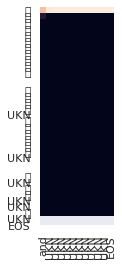

In [80]:
#plotting
n = 6
#bleu_3_no_unk, att_score_w, pred_w, src_w
draw(att_score_w[n],pred_w[n],src_w[n])